In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score
from sklearn.preprocessing import label_binarize
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#HELPER CODE

#Validation Method
def performValidation(model, data, realScores, aucName):
    #DT Accuracy
    print("*****DECISION TREE*****")
    y_pred = model.predictDTScoreSet(data)
    
    acc = accuracy_score(realScores,y_pred)
    recall = recall_score(realScores,y_pred,average='weighted')
    f1 = f1_score(realScores,y_pred,average='weighted')
    prec = precision_score(realScores,y_pred,average='weighted')
    
    #ROC AUC Score
    y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
    y_test = label_binarize(realScores, classes=[1,2,3,4,5])
    fpr, tpr, roc_auc = mvGen.getClassROC(y_test,y_score)
    
    mvGen.getAverageROCGraph(fpr, tpr, roc_auc, aucName)

    print("DT Accuracy:", acc)
    print("DT Recall:", recall)
    print("DT F1 Score:", f1)
    print("DT Precision:", prec)
    
    #MVDD Accuracy
    print("\n*****MVDD*****")
    y_pred = model.predictScoreSet(data)
    
    acc = accuracy_score(realScores,y_pred)
    recall = recall_score(realScores,y_pred,average='weighted')
    f1 = f1_score(realScores,y_pred,average='weighted')
    prec = precision_score(realScores,y_pred,average='weighted')
    
    #ROC AUC Score
    y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
    y_test = label_binarize(realScores, classes=[1,2,3,4,5])
    fpr, tpr, roc_auc = mvGen.getClassROC(y_test,y_score)
    
    mvGen.getAverageROCGraph(fpr, tpr, roc_auc, aucName)

    print("Accuracy:", acc)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Precision:", prec)
    
    return acc, recall, f1, prec

# ESCAPE training - Hemo - Death

In [3]:
#Load original dataframes
hemoData = pd.read_csv('Data/Preprocessed Data/ESCAPE_AC_Hemo.csv', index_col='DEIDNUM')
allScores = hemoData['Score']
death = hemoData['ScoreDeath']
rehosp = hemoData['ScoreRehosp']
readm = hemoData['ScoreReadmission']
hemoData

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,1,1,3,1
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,1,1,3,1
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,4,2,5,3
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,4,2,5,3
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,4,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,3,4,1,5
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,5,3,4,4
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,5,3,4,4


In [4]:
# Preprocess and create training and testing sets
hemo = hemoData.drop('Score', axis=1)
hemo = hemo.drop('ScoreDeath', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

xData = hemo
yData = death
xData.shape, yData.shape

((418, 28), (418,))


Total edges: 48 Nonterminal Edge 23
Must have more than 7 and less than 14 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.9404761904761905
Accuracy MVDD: 0.47619047619047616


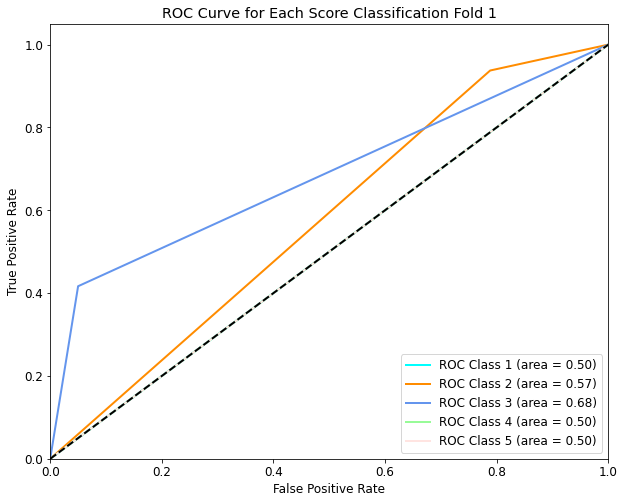


Total edges: 38 Nonterminal Edge 18
Must have more than 5 and less than 11 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.9047619047619048
Accuracy MVDD: 0.5952380952380952


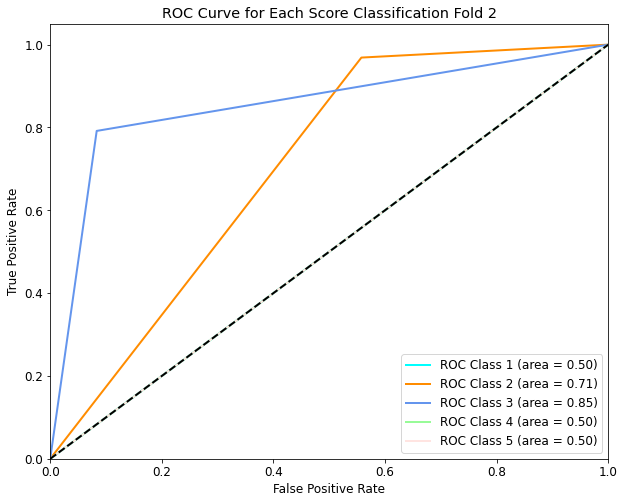


Total edges: 46 Nonterminal Edge 22
Must have more than 7 and less than 13 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.9285714285714286
Accuracy MVDD: 0.5714285714285714


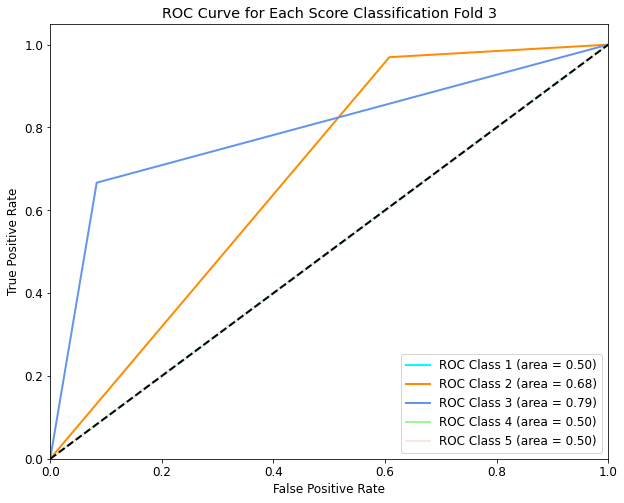


Total edges: 48 Nonterminal Edge 23
Must have more than 7 and less than 14 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.8795180722891566
Accuracy MVDD: 0.43373493975903615


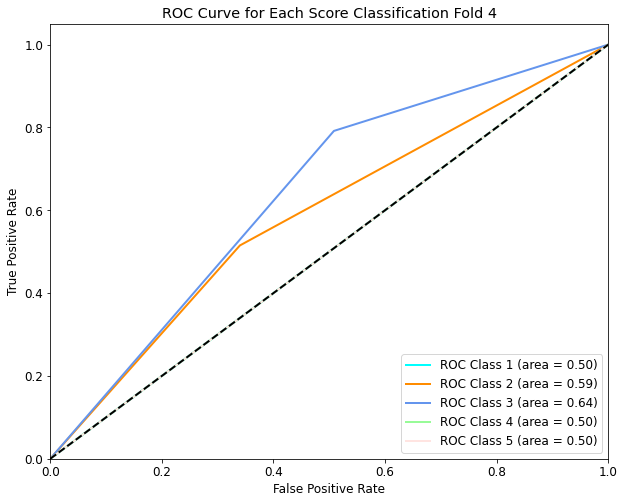


Total edges: 44 Nonterminal Edge 21
Must have more than 6 and less than 13 OR Edges


In [ ]:
mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='AC_Hemo_Death', numFolds=5, 
                                        showIndividualROC=True)

## ARIC Cohort Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_Hemo_Death')

In [ ]:
hemoCohort = pd.read_csv("Data Validation/ARIC/Preprocessed Data/ARIC_Cohort_AC_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoAricCohort')

## ARIC Comm Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_Hemo_Death')

In [ ]:
hemoCohort = pd.read_csv("Data Validation/ARIC/Preprocessed Data/ARIC_Comm_AC_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoAricComm')

# ESCAPE Training - All Data - Death

In [ ]:
#Load original dataframes
allData = pd.read_csv('Data/Preprocessed Data/ESCAPE_AC_AllData.csv', index_col='DEIDNUM')
allScores = allData['Score']
death = allData['ScoreDeath']
rehosp = allData['ScoreRehosp']
readm = allData['ScoreReadmission']
allData

In [ ]:
# Preprocess and create training and testing sets
alld = allData.drop('Score', axis=1)
alld = alld.drop('ScoreDeath', axis=1)
alld = alld.drop('ScoreRehosp', axis=1)
alld = alld.drop('ScoreReadmission', axis=1)
alld = alld.replace(np.inf, 0)
alld = alld.fillna(0)

xData = alld
yData = death
xData.shape, yData.shape

In [ ]:
mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='AC_AllData_Death', numFolds=5, 
                                        showIndividualROC=True)

# ARIC Cohort All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_AllData_Death')

In [ ]:
allDataCohort = pd.read_csv("Data Validation/ARIC/Preprocessed Data/ARIC_Cohort_AC_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataAricCohort')

# ARIC Comm All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_AllData_Death')

In [ ]:
allDataCohort = pd.read_csv("Data Validation/ARIC/Preprocessed Data/ARIC_Comm_AC_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataAricComm')

# GUIDE-IT All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_AllData_Death')

In [ ]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AC_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataGuideIt')